## Model Training
for Tree based models

In [1]:
# Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date

# Set float display to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Wranings 
import warnings
warnings.filterwarnings('ignore')

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 3, Finished, Available, Finished)

### Read Data

In [2]:
# Read data 
train_df = pd.read_parquet("/lakehouse/default/Files/train/train_df.parquet")
train_df.head()

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 4, Finished, Available, Finished)

,hvfhs_license_num,pickup_datetime,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,cbd_congestion_fee,week_number
11322195,HV0003,2025-06-18 12:40:39,10.95,1683,37.72,0.00,0.95,3.35,0.00,0.00,0.00,32.46,N,N,N,N,N,0.00,25
12984601,HV0003,2025-06-20 21:29:28,8.89,2445,12.59,0.00,0.32,1.12,0.00,0.00,0.00,25.17,Y,Y,N,N,N,0.00,25
5431662,HV0003,2025-06-09 10:31:29,1.15,395,9.82,0.00,0.24,0.87,0.00,0.00,0.00,5.61,N,N,N,N,N,0.00,24
15867325,HV0003,2025-06-25 02:08:11,5.74,1110,32.51,0.00,0.78,2.89,2.75,0.00,3.89,19.30,N,N,N,N,N,1.50,26
13701913,HV0003,2025-06-21 20:52:19,3.17,1360,14.68,0.00,0.36,1.30,0.00,0.00,0.00,16.53,Y,Y,N,N,N,0.00,25


In [3]:
# Shape 
train_df.shape

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 5, Finished, Available, Finished)

(2000000, 19)

In [4]:
# Info 
train_df.info()

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 6, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 11322195 to 6340764
Data columns (total 19 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   pickup_datetime       datetime64[ns]
 2   trip_miles            float64       
 3   trip_time             int64         
 4   base_passenger_fare   float64       
 5   tolls                 float64       
 6   bcf                   float64       
 7   sales_tax             float64       
 8   congestion_surcharge  float64       
 9   airport_fee           float64       
 10  tips                  float64       
 11  driver_pay            float64       
 12  shared_request_flag   object        
 13  shared_match_flag     object        
 14  access_a_ride_flag    object        
 15  wav_request_flag      object        
 16  wav_match_flag        object        
 17  cbd_congestion_fee    float64       
 18  week_number           UInt32        
dty

### Features & Transformations

#### Derived Features

In [5]:
# Copy df
train_df1 = train_df.copy()

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 7, Finished, Available, Finished)

In [6]:
# Shape 
train_df1.shape

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 8, Finished, Available, Finished)

(2000000, 19)

In [7]:
# Time-based features
train_df1['pickup_hour'] = train_df1['pickup_datetime'].dt.hour
train_df1['pickup_dayofweek'] = train_df1['pickup_datetime'].dt.dayofweek
train_df1['is_weekend'] = train_df1['pickup_dayofweek'].isin([5, 6]).astype(int)
train_df1['pickup_dayofmonth'] = train_df1['pickup_datetime'].dt.day
# Time of day category (morning, afternoon, night, etc.)
train_df1['time_of_day'] = pd.cut(train_df1['pickup_hour'], bins=[0,6,12,18,24], 
        labels=['Night','Morning','Afternoon','Evening'], right=False)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 9, Finished, Available, Finished)

In [8]:
train_df1.columns

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 10, Finished, Available, Finished)

Index(['hvfhs_license_num', 'pickup_datetime', 'trip_miles', 'trip_time',
       'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'cbd_congestion_fee',
       'week_number', 'pickup_hour', 'pickup_dayofweek', 'is_weekend',
       'pickup_dayofmonth', 'time_of_day'],
      dtype='object')

In [9]:
# Drop Columns 
train_df1.drop(['pickup_datetime', 'week_number', 'pickup_hour', 
                'pickup_dayofmonth'], axis=1, inplace=True)
train_df1.info()

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 11, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 11322195 to 6340764
Data columns (total 20 columns):
 #   Column                Dtype   
---  ------                -----   
 0   hvfhs_license_num     object  
 1   trip_miles            float64 
 2   trip_time             int64   
 3   base_passenger_fare   float64 
 4   tolls                 float64 
 5   bcf                   float64 
 6   sales_tax             float64 
 7   congestion_surcharge  float64 
 8   airport_fee           float64 
 9   tips                  float64 
 10  driver_pay            float64 
 11  shared_request_flag   object  
 12  shared_match_flag     object  
 13  access_a_ride_flag    object  
 14  wav_request_flag      object  
 15  wav_match_flag        object  
 16  cbd_congestion_fee    float64 
 17  pickup_dayofweek      int32   
 18  is_weekend            int64   
 19  time_of_day           category
dtypes: category(1), float64(10), int32(1), int64(2), object(6)
memory usage: 299.5+ MB


#### 1/0 encoding
Converting Y/N columns to 1/0

In [10]:
# Set license_num to category, trip time to float64 (same as other continuous variables)
train_df1['hvfhs_license_num'] = train_df['hvfhs_license_num'].astype('category')
train_df1['trip_time'] = train_df1['trip_time'].astype('float64')

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 12, Finished, Available, Finished)

In [11]:
# Set features for encoding
encoded_features = train_df1.select_dtypes('object').columns 
encoded_features

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 13, Finished, Available, Finished)

Index(['shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [12]:
# Mapping features with Y/N to 1/0
mapping = {'Y': 1, 'N': 0}

# Loop through columns, map to new values from dic
for col in encoded_features: 
    train_df1[col] = train_df1[col].map(mapping)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 14, Finished, Available, Finished)

In [13]:
# Info 
train_df1.info()

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 15, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 11322195 to 6340764
Data columns (total 20 columns):
 #   Column                Dtype   
---  ------                -----   
 0   hvfhs_license_num     category
 1   trip_miles            float64 
 2   trip_time             float64 
 3   base_passenger_fare   float64 
 4   tolls                 float64 
 5   bcf                   float64 
 6   sales_tax             float64 
 7   congestion_surcharge  float64 
 8   airport_fee           float64 
 9   tips                  float64 
 10  driver_pay            float64 
 11  shared_request_flag   int64   
 12  shared_match_flag     int64   
 13  access_a_ride_flag    int64   
 14  wav_request_flag      int64   
 15  wav_match_flag        int64   
 16  cbd_congestion_fee    float64 
 17  pickup_dayofweek      int32   
 18  is_weekend            int64   
 19  time_of_day           category
dtypes: category(2), float64(11), int32(1), int64(6)
memory usage: 286.1 MB


### Correlations

In [14]:
# describe Continuous features 
train_df1.select_dtypes('float64').describe()

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 16, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,cbd_congestion_fee
count,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00
mean,5.12,1218.97,28.00,1.12,0.70,2.33,0.97,0.23,1.24,21.60,0.51
std,6.01,898.32,25.70,3.63,0.67,2.12,1.31,0.72,3.72,18.91,0.71
min,0.01,1.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
25%,1.56,600.00,12.67,0.00,0.31,1.04,0.00,0.00,0.00,9.48,0.00
50%,3.03,978.00,19.99,0.00,0.49,1.68,0.00,0.00,0.00,16.05,0.00
75%,6.42,1566.00,33.57,0.00,0.84,2.86,2.75,0.00,0.00,27.25,1.50
max,266.56,29430.00,1069.28,65.59,26.73,97.29,5.50,10.00,179.14,692.87,3.00


In [15]:
# Set continuous features 
continuous_features = train_df.select_dtypes('float64').columns

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 17, Finished, Available, Finished)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 18, Finished, Available, Finished)

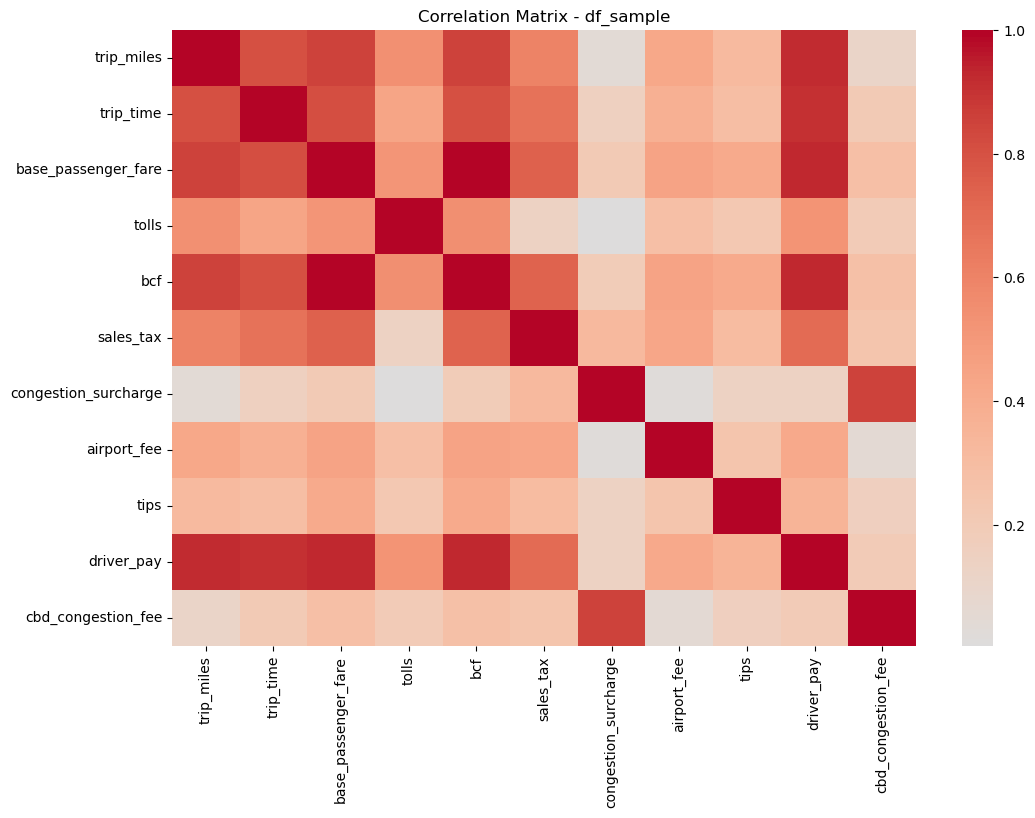

                      trip_miles  trip_time  base_passenger_fare  tolls  bcf  \
trip_miles                  1.00       0.80                 0.85   0.54 0.85   
trip_time                   0.80       1.00                 0.81   0.44 0.81   
base_passenger_fare         0.85       0.81                 1.00   0.52 0.99   
tolls                       0.54       0.44                 0.52   1.00 0.55   
bcf                         0.85       0.81                 0.99   0.55 1.00   
sales_tax                   0.60       0.67                 0.75   0.14 0.73   
congestion_surcharge        0.05       0.15                 0.20   0.00 0.19   
airport_fee                 0.43       0.38                 0.45   0.28 0.45   
tips                        0.32       0.29                 0.41   0.22 0.41   
driver_pay                  0.92       0.91                 0.93   0.52 0.93   
cbd_congestion_fee          0.11       0.21                 0.28   0.20 0.27   

                      sales_tax  conges

In [16]:
# calculate correlations only for numeric columns (continous only, not categorical)
corr_matrix = train_df1.select_dtypes(include='float64').corr(numeric_only=True)

# display as heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix - df_sample")
plt.show()

# if you want to check only correlation with the target
print(corr_matrix)

### Selecting Features (X), Target (y)

In [17]:
# Columns 
train_df1.columns

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 19, Finished, Available, Finished)

Index(['hvfhs_license_num', 'trip_miles', 'trip_time', 'base_passenger_fare',
       'tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'airport_fee',
       'tips', 'driver_pay', 'shared_request_flag', 'shared_match_flag',
       'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag',
       'cbd_congestion_fee', 'pickup_dayofweek', 'is_weekend', 'time_of_day'],
      dtype='object')

In [18]:
# Target 
y = train_df1['driver_pay']

# Features (change per modelling demands)
X = train_df1.drop("driver_pay", axis=1)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 20, Finished, Available, Finished)

In [19]:
# Shape
print ("Shape of features (X):", X.shape)
print ("Shape of target (y):", y.shape)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 21, Finished, Available, Finished)

Shape of features (X): (2000000, 19)
Shape of target (y): (2000000,)


### Train Test Split 

In [20]:
# Train - test split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 22, Finished, Available, Finished)

In [21]:
# Shape 
print ("Shape of X_train:", X_train.shape)
print ("Shape of y_train:", y_train.shape)
print ("Shape of X_test:", X_test.shape)
print ("Shape of y_text:", y_test.shape)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 23, Finished, Available, Finished)

Shape of X_train: (1600000, 19)
Shape of y_train: (1600000,)
Shape of X_test: (400000, 19)
Shape of y_text: (400000,)


###  LightGBM 

In [22]:
# Libraries for LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 24, Finished, Available, Finished)

In [23]:
# Data conversion
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 25, Finished, Available, Finished)

In [24]:
# Parameters (good starting point)
params = {
    "objective": "regression",
    "metric": ["mae", "rmse"],
    "boosting_type": "gbdt",   # gradient boosting
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 26, Finished, Available, Finished)

In [25]:
# selecting model
model = LGBMRegressor(
    objective="regression",
    learning_rate=0.05,
    num_leaves=101,
    n_estimators=1000,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1
)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 27, Finished, Available, Finished)

In [26]:
# Training & Fitting
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    callbacks=[early_stopping(stopping_rounds=100), log_evaluation(50)]
)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 28, Finished, Available, Finished)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 3.83358	valid_0's l2: 14.6964
[100]	valid_0's rmse: 3.43303	valid_0's l2: 11.7857
[150]	valid_0's rmse: 3.41133	valid_0's l2: 11.6372
[200]	valid_0's rmse: 3.41214	valid_0's l2: 11.6427
[250]	valid_0's rmse: 3.40653	valid_0's l2: 11.6044
[300]	valid_0's rmse: 3.40871	valid_0's l2: 11.6193
Early stopping, best iteration is:
[248]	valid_0's rmse: 3.40646	valid_0's l2: 11.6039


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              learning_rate=0.05, n_estimators=1000, num_leaves=101,
              objective='regression', verbose=-1)

In [27]:
# Predictions 
y_pred_test = model.predict(X_test)             # for test set
y_pred_train = model.predict(X_train)           # for train set

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 29, Finished, Available, Finished)

In [28]:
# Metrics
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 30, Finished, Available, Finished)

MAE: 1.56
RMSE: 3.41
R²: 0.9676


### Predictions

In [29]:
# Shape 
print ("Shape of X_test:", X_test.shape)
print ("Shape of y_test:", y_test.shape)
print ("Shape of y_pred:", y_pred_test.shape)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 31, Finished, Available, Finished)

Shape of X_test: (400000, 19)
Shape of y_test: (400000,)
Shape of y_pred: (400000,)


#### Building train and test sets with Predictions

In [30]:
# Actual vs. predicted on train data
train_results_df = pd.DataFrame({'actuals': y_train, "predicted": y_pred_train, 
                    "series": "train"}, index=X_train.index)
train_results_df.head()

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 32, Finished, Available, Finished)

,actuals,predicted,series
12241079,13.52,15.32,train
18091860,57.83,55.63,train
16448350,28.69,30.40,train
11087488,9.54,9.94,train
7233263,12.63,11.45,train


In [31]:
# actuals vs. predicted on test data
test_results_df = pd.DataFrame({'actuals': y_test, "predicted": y_pred_test, 
                    "series": "test"}, index=X_test.index)
test_results_df.head()

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 33, Finished, Available, Finished)

,actuals,predicted,series
855,4.98,5.23,test
14936740,9.97,10.33,test
19795069,24.25,25.23,test
9899619,14.87,27.42,test
11671988,145.61,159.16,test


In [32]:
# Vertically concatenate 
results_df = pd.concat([train_results_df, test_results_df]).sort_index()
results_df.head()

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 34, Finished, Available, Finished)

,actuals,predicted,series
0,59.78,61.80,train
2,17.82,20.32,test
36,15.07,15.78,train
40,11.75,9.06,train
62,12.03,13.81,test


In [33]:
display(results_df)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 35, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, cf5fa1a5-4a5e-4a77-9c7e-e5d194585baa)

In [34]:
# concat with initial training data
final_df = pd.concat ([train_df['pickup_datetime'] , train_df1, results_df], axis=1)
display(final_df)

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 36, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 2cee80f5-0f04-4325-a5f6-77fc606907e2)

#### Save model to lakehouse 

In [35]:
# Libraries 
import joblib

# Save model
joblib.dump(model, "/lakehouse/default/Files/models/LightGBM_model.pkl")

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 37, Finished, Available, Finished)

['/lakehouse/default/Files/models/LightGBM_model.pkl']

In [36]:
# Save predictions to fabric warehouse 
spark.createDataFrame(final_df).write.format("delta").mode(
    "overwrite").option("overwriteSchema", "true").saveAsTable("trained_final_df_lgbm")

StatementMeta(, 169159b5-0152-44e4-87fa-6b32a7aa1d51, 38, Finished, Available, Finished)